# Project 3 - Reddit webscraping
by Liyena Yusoff

[Part I - Data Cleaning](Data_Cleaning.ipynb)

[Part III - Pre-Processing and Modeling](Pre_Processing_Model.ipynb)

## Contents:

* Exploratory Data Analysis:
    - Unigrams
    - Bi-grams

## Problem Statement
As the marketing team at Netflix, our primary objective is to boost website traffic and increase the number of sign-ups for our streaming service. To achieve this, we aim to develop a machine learning classifier to analyze Netflix and Disney+ Reddit posts, distinguishing between discussions related to Netflix and Disney+. The model will identify unique words and phrases associated specifically with Netflix, allowing us to understand what sets us apart in public perception.

## Goal

The goal of the project is to utilize the unique words and insights for the company's marketing campaigns to amplify our unique selling points, thereby driving more traffic to our website and increasing subscriber sign-ups.

## Stakeholders

1. Netflix Marketing Team
2. Netflix Content team

## Success metrics
* F1-score

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup

# 1. Load cleaned data

In [2]:
df_text = pd.read_csv('datasets/cleaned_data_text_only.csv')
df = pd.read_csv('datasets/cleaned_data.csv') 

In [3]:
df.head()

,title,selftext,ups,upvote_ratio,num_comments,author,link_flair_text,awards,is_original_content,is_video,...,domain,created_utc,pinned,locked,stickied,readable_time,subreddit,text,proc_text,proc_text_lem
0,/r/Netflix Discord Server,We are pleased to announce we have affiliated ...,427,0.97,182,N3DSdude,Announcement,3,False,False,...,self.netflix,1.619278e+09,False,False,True,2021-04-24 15:24:04,1,/r/Netflix Discord Server We are pleased to an...,r netflix discord server pleased announce affi...,r netflix discord server pleased announce affi...
1,Netflix Announces Plans to Crack Down on Passw...,> **Any post relating to this thread will now ...,661,0.94,3069,UniversallySecluded,Megathread,0,False,False,...,self.netflix,1.675331e+09,False,False,True,2023-02-02 09:35:27,1,Netflix Announces Plans to Crack Down on Passw...,netflix announces plans crack password sharing...,netflix announce plan crack password sharing m...
2,Any tips for de-morbiding your feed?,This is on behalf of a friend although my feed...,9,0.76,3,Scully__,others,0,False,False,...,self.netflix,1.694473e+09,False,False,False,2023-09-11 23:00:51,1,Any tips for de-morbiding your feed? This is o...,tips de morbiding feed behalf friend although ...,tip de morbide feed behalf friend although fee...
3,Why did netflix remove some profile pictures?,Was using one of the one piece profile picture...,11,0.64,6,ironshadowy,others,0,False,False,...,self.netflix,1.694448e+09,False,False,False,2023-09-11 15:57:38,1,Why did netflix remove some profile pictures? ...,netflix remove profile pictures using one one ...,netflix remove profile picture use one one pie...
4,One Piece Issue?,I saw episode one and two earlier and they wer...,2,1.00,0,ussjtrunksftw,others,0,False,False,...,self.netflix,1.694478e+09,False,False,False,2023-09-12 00:19:47,1,One Piece Issue? I saw episode one and two ear...,one piece issue saw episode one two earlier fi...,one piece issue see episode one two early fine...


In [4]:
df_text.head()

,readable_time,subreddit,author,title,selftext,text,proc_text,proc_text_lem,char_length,word_count
0,2021-04-24 15:24:04,1,N3DSdude,/r/Netflix Discord Server,We are pleased to announce we have affiliated ...,/r/Netflix Discord Server We are pleased to an...,r netflix discord server pleased announce affi...,r netflix discord server pleased announce affi...,178,24
1,2023-02-02 09:35:27,1,UniversallySecluded,Netflix Announces Plans to Crack Down on Passw...,> **Any post relating to this thread will now ...,Netflix Announces Plans to Crack Down on Passw...,netflix announces plans crack password sharing...,netflix announce plan crack password sharing m...,576,78
2,2023-09-11 23:00:51,1,Scully__,Any tips for de-morbiding your feed?,This is on behalf of a friend although my feed...,Any tips for de-morbiding your feed? This is o...,tips de morbiding feed behalf friend although ...,tip de morbide feed behalf friend although fee...,301,44
3,2023-09-11 15:57:38,1,ironshadowy,Why did netflix remove some profile pictures?,Was using one of the one piece profile picture...,Why did netflix remove some profile pictures? ...,netflix remove profile pictures using one one ...,netflix remove profile picture use one one pie...,174,24
4,2023-09-12 00:19:47,1,ussjtrunksftw,One Piece Issue?,I saw episode one and two earlier and they wer...,One Piece Issue? I saw episode one and two ear...,one piece issue saw episode one two earlier fi...,one piece issue see episode one two early fine...,217,34


We will be including the day of the week in `df` to explore the distribution of time and day of the posts on the subreddits. To do this, we will be forming a function on the obtain the day in string from the `readable_time`.

In [5]:
def get_day_time(df):
    df['readable_time'] = pd.to_datetime(df['readable_time'])
    df['day'] = df['readable_time'].apply(lambda x: x.strftime("%A"))
    df['time'] = df['readable_time'].dt.hour
    return df

In [6]:
get_day_time(df_text)
df_text.head()

,readable_time,subreddit,author,title,selftext,text,proc_text,proc_text_lem,char_length,word_count,day,time
0,2021-04-24 15:24:04,1,N3DSdude,/r/Netflix Discord Server,We are pleased to announce we have affiliated ...,/r/Netflix Discord Server We are pleased to an...,r netflix discord server pleased announce affi...,r netflix discord server pleased announce affi...,178,24,Saturday,15
1,2023-02-02 09:35:27,1,UniversallySecluded,Netflix Announces Plans to Crack Down on Passw...,> **Any post relating to this thread will now ...,Netflix Announces Plans to Crack Down on Passw...,netflix announces plans crack password sharing...,netflix announce plan crack password sharing m...,576,78,Thursday,9
2,2023-09-11 23:00:51,1,Scully__,Any tips for de-morbiding your feed?,This is on behalf of a friend although my feed...,Any tips for de-morbiding your feed? This is o...,tips de morbiding feed behalf friend although ...,tip de morbide feed behalf friend although fee...,301,44,Monday,23
3,2023-09-11 15:57:38,1,ironshadowy,Why did netflix remove some profile pictures?,Was using one of the one piece profile picture...,Why did netflix remove some profile pictures? ...,netflix remove profile pictures using one one ...,netflix remove profile picture use one one pie...,174,24,Monday,15
4,2023-09-12 00:19:47,1,ussjtrunksftw,One Piece Issue?,I saw episode one and two earlier and they wer...,One Piece Issue? I saw episode one and two ear...,one piece issue saw episode one two earlier fi...,one piece issue see episode one two early fine...,217,34,Tuesday,0


# II. Exploratory Data Analysis

In [81]:
df_text.describe(include='all')

/var/folders/k7/8c5x2ygj2td4rpnn786dd9480000gp/T/ipykernel_94923/2906255205.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_text.describe(include='all')


,readable_time,subreddit,author,title,selftext,text,proc_text,proc_text_lem,char_length,word_count,day,time
count,3022,3022.000000,3022,3022,3022,3022,3022,3022,3022.000000,3022.000000,3022,3022.000000
unique,3022,NaN,2520,3006,3018,3022,3022,3022,NaN,NaN,7,NaN
top,2021-04-24 15:24:04,NaN,None,Help,"For a thriller, it didn’t possess many suspens...",/r/Netflix Discord Server We are pleased to an...,r netflix discord server pleased announce affi...,r netflix discord server pleased announce affi...,NaN,NaN,Sunday,NaN
freq,1,NaN,232,5,2,1,1,1,NaN,NaN,506,NaN
first,2011-06-23 20:49:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-09-12 01:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.559232,NaN,NaN,NaN,NaN,NaN,NaN,391.458637,57.388154,NaN,12.227333
std,NaN,0.496561,NaN,NaN,NaN,NaN,NaN,NaN,591.040015,84.931812,NaN,7.271507
min,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,1.000000,NaN,0.000000
25%,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,142.000000,21.000000,NaN,5.000000


Across the two subreddits, it seems that the most posts are posted on Sunday.

In [80]:
# filtering the data by subreddits

df_text_nf = df_text.loc[df_text['subreddit'] == 1]
df_text_dp = df_text.loc[df_text['subreddit'] == 0]
display(df_text_nf.head())
display(df_text_dp.head())

,readable_time,subreddit,author,title,selftext,text,proc_text,proc_text_lem,char_length,word_count,day,time
0,2021-04-24 15:24:04,1,N3DSdude,/r/Netflix Discord Server,We are pleased to announce we have affiliated ...,/r/Netflix Discord Server We are pleased to an...,r netflix discord server pleased announce affi...,r netflix discord server pleased announce affi...,178,24,Saturday,15
1,2023-02-02 09:35:27,1,UniversallySecluded,Netflix Announces Plans to Crack Down on Passw...,> **Any post relating to this thread will now ...,Netflix Announces Plans to Crack Down on Passw...,netflix announces plans crack password sharing...,netflix announce plan crack password sharing m...,576,78,Thursday,9
2,2023-09-11 23:00:51,1,Scully__,Any tips for de-morbiding your feed?,This is on behalf of a friend although my feed...,Any tips for de-morbiding your feed? This is o...,tips de morbiding feed behalf friend although ...,tip de morbide feed behalf friend although fee...,301,44,Monday,23
3,2023-09-11 15:57:38,1,ironshadowy,Why did netflix remove some profile pictures?,Was using one of the one piece profile picture...,Why did netflix remove some profile pictures? ...,netflix remove profile pictures using one one ...,netflix remove profile picture use one one pie...,174,24,Monday,15
4,2023-09-12 00:19:47,1,ussjtrunksftw,One Piece Issue?,I saw episode one and two earlier and they wer...,One Piece Issue? I saw episode one and two ear...,one piece issue saw episode one two earlier fi...,one piece issue see episode one two early fine...,217,34,Tuesday,0


,readable_time,subreddit,author,title,selftext,text,proc_text,proc_text_lem,char_length,word_count,day,time
1690,2023-09-06 17:04:21,0,AutoModerator,This is the Weekly Tech Support Thread,All posts regarding tech support belong here.\...,This is the Weekly Tech Support Thread All pos...,weekly tech support thread posts regarding tec...,weekly tech support thread post regard tech su...,212,30,Wednesday,17
1691,2023-08-22 18:38:53,0,anonRedd,Ahsoka - Episodes 1 and 2 Megathread,Ahsoka is (almost) here!\n\nStart streaming th...,Ahsoka - Episodes 1 and 2 Megathread Ahsoka is...,ahsoka episodes megathread ahsoka almost start...,ahsoka episode megathread ahsoka almost start ...,98,14,Tuesday,18
1692,2023-09-11 10:35:02,0,kindaweird0,For a while I was very reticent about watching...,"… I loved it. It’s not the original, it’s a re...",For a while I was very reticent about watching...,reticent watching movie yesterday thanks final...,reticent watch movie yesterday thank finally l...,312,46,Monday,10
1693,2023-09-12 01:36:00,0,thekirasquad,You guys think that Hulu would be like Star fo...,"Personally, I am very excited about the merger...",You guys think that Hulu would be like Star fo...,guys think hulu would like star us merger one ...,guy think hulu would like star we merger one a...,560,92,Tuesday,1
1694,2023-09-11 19:59:45,0,ArsenalThePhoenix,Can Disney+ run 1080p or 4K on a PC now?,I keep finding threads that are 2-3 year olds ...,Can Disney+ run 1080p or 4K on a PC now? I kee...,disney run p k pc keep finding threads year ol...,disney run p k pc keep find thread year old ba...,111,21,Monday,19


In [9]:
# word count and char count distribution

def distr_chart(df1, df2, word_char_length):
    sns.histplot(df1[word_char_length], bins=50)
    sns.histplot(df2[word_char_length], bins=50)
    plt.title('Distribution of '+ word_char_length)
    plt.show()

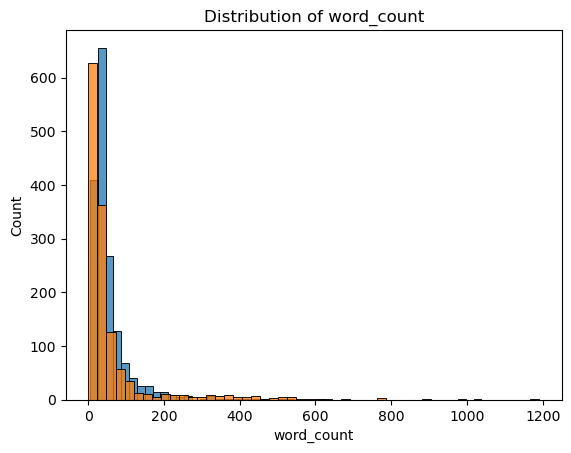

In [10]:
distr_chart(df_text_nf,df_text_dp, 'word_count')

The word count from both subreddits are right skewed. Because they are not linearly separable, we cannot distinguish the different subgroups from the word count of each post.

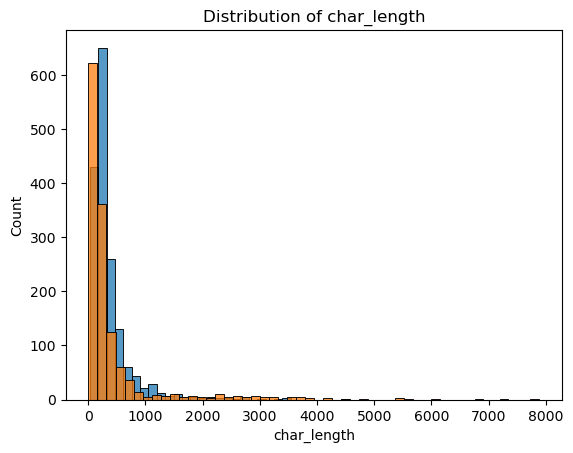

In [11]:
distr_chart(df_text_nf,df_text_dp, 'char_length')

Similarly, the character length is also non-linearly separable and we cannot distinguish the posts between the different subreddits.

**When is the most common time and day for users to post on the subreddit?**

In [82]:
# filtering the netflix df by grouping them by the day and time
filter_days_nf = df_text_nf.groupby(['day','time'])['subreddit'].count()
day = filter_days_nf.index
value = filter_days_nf.values

# Sample days_of_week with correct order
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reorder the index of filter_days_nf based on days_of_week
filter_days_nf = filter_days_nf.reindex(index=pd.MultiIndex.from_product([days_of_week, filter_days_nf.index.levels[1]]))

# If needed, you can reset the index to make it a regular DataFrame
filter_days_nf = filter_days_nf.reset_index()

# Display the reordered DataFrame
filter_days_nf


,level_0,time,subreddit
0,Monday,0,12
1,Monday,1,14
2,Monday,2,18
3,Monday,3,8
4,Monday,4,11
...,...,...,...
163,Sunday,19,23
164,Sunday,20,22
165,Sunday,21,13
166,Sunday,22,10


### At which day and time were there more posts?

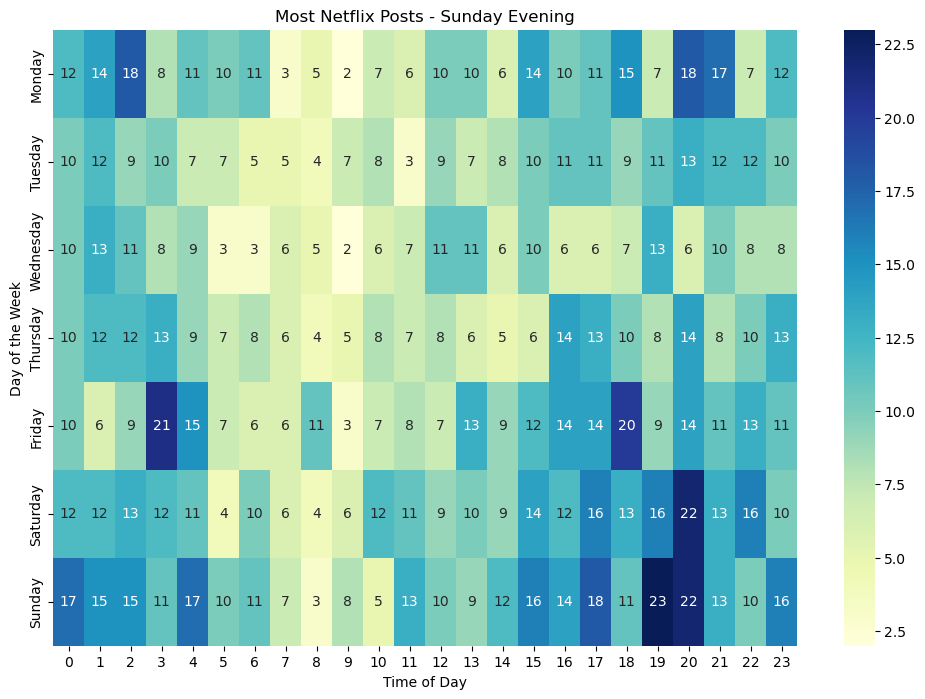

In [13]:
filter_days_nf['level_0'] = pd.Categorical(filter_days_nf['level_0'], categories=days_of_week, ordered=True)

# Reshape the DataFrame to have days as rows and times as columns
heatmap_data = filter_days_nf.pivot(index='level_0', columns='time', values='subreddit')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', cbar=True)
plt.title('Most Netflix Posts - Sunday Evening')
plt.xlabel('Time of Day')
plt.ylabel('Day of the Week')

# Show the heatmap
plt.show()

For the Netflix subreddit, most of the posts were posted on Saturday and Sunday evenings between 7pm to 9pm. It is also important to pay attention that in general, there are more posts in the evenings till the wee hours each day.

In [83]:
# filtering the Disney+ df by grouping them by the day and time of post
filter_days_dp = df_text_dp.groupby(['day','time'])['subreddit'].count()
day = filter_days_dp.index
value = filter_days_dp.values

# Sample days_of_week with correct order
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reorder the index of filter_days_nf based on days_of_week
filter_days_dp = filter_days_dp.reindex(index=pd.MultiIndex.from_product([days_of_week, filter_days_dp.index.levels[1]]))

# If needed, you can reset the index to make it a regular DataFrame
filter_days_dp = filter_days_dp.reset_index()

# Display the reordered DataFrame
filter_days_dp


,level_0,time,subreddit
0,Monday,0,5
1,Monday,1,9
2,Monday,2,9
3,Monday,3,6
4,Monday,4,10
...,...,...,...
163,Sunday,19,16
164,Sunday,20,15
165,Sunday,21,5
166,Sunday,22,9


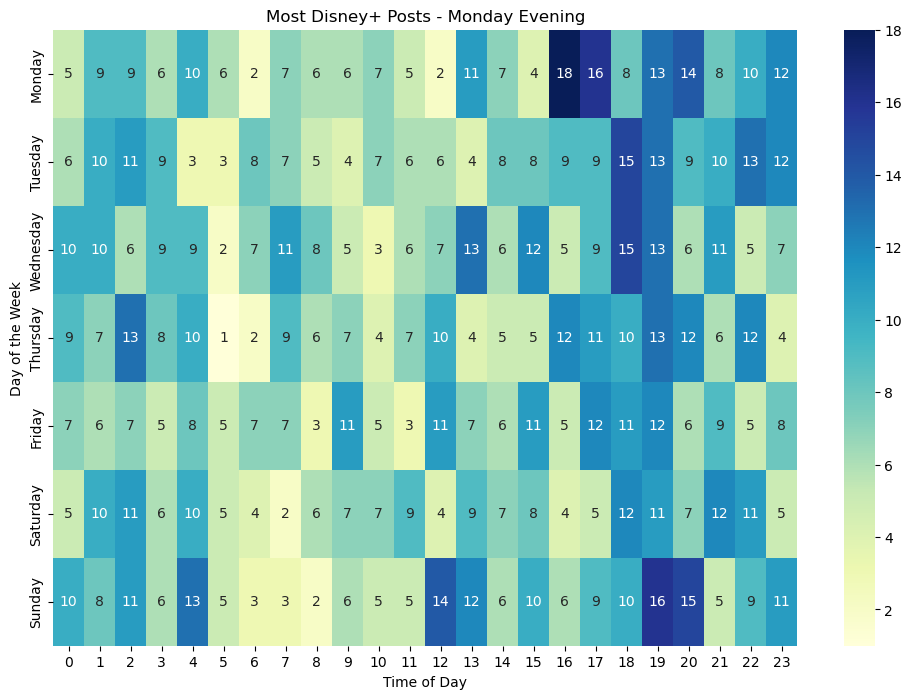

In [15]:
filter_days_dp['level_0'] = pd.Categorical(filter_days_dp['level_0'], categories=days_of_week, ordered=True)

# Reshape the DataFrame to have days as rows and times as columns
heatmap_data = filter_days_dp.pivot(index='level_0', columns='time', values='subreddit')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', cbar=True)
plt.title('Most Disney+ Posts - Monday Evening')
plt.xlabel('Time of Day')
plt.ylabel('Day of the Week')

# Show the heatmap
plt.show()

On the contrary, the posts on the Disney+ subreddit were mostly posted on Monday between 4pm to 6pm and on Sunday between 7pm to 9pm.

These heatmaps are useful for the marketing team as this allows them to schedule the best day and time to launch the campaign. The content team could also utilise these heatmaps to schedule trailer release.

## a. Uni-grams and bi-grams

In [84]:
# obtaining on the `proc_text_lem` and `subreddit` columns for EDA
df_eda = df_text[['proc_text_lem','subreddit']]

# filtering only the Netflix posts
df_netflix = df_eda[df_eda['subreddit']==1]['proc_text_lem']

# filtering only the Disney+ posts
df_disneyplus = df_eda[df_eda['subreddit']==0]['proc_text_lem']

In [68]:
# instantiating the vectorizers for unigrams and bi-grams

custom_stop_words = ['like', 'get', 'feel', 'would', 'think','know']

cvec = CountVectorizer(stop_words=custom_stop_words)
tfidf = TfidfVectorizer(stop_words=custom_stop_words)
cvec_bigram = CountVectorizer(ngram_range=(2,2), stop_words=custom_stop_words)
tfidf_bigram = TfidfVectorizer(ngram_range=(2,2), stop_words=custom_stop_words)

# forming a function to vectorize text into unigrams

def get_unigram(df, vectorizer):
    df_eda = pd.DataFrame(vectorizer.fit_transform(df).toarray(), columns =vectorizer.get_feature_names_out())

    return df_eda

# forming a function to vectorize text into bi-grams

def get_bigram(df, vectorizer):
    df_eda = pd.DataFrame(vectorizer.fit_transform(df).toarray(), columns =vectorizer.get_feature_names_out())

    return df_eda

In [74]:
# obtaining unigrams with CountVectorizer

df_netflix_eda = get_unigram(df_netflix, cvec)
df_disneyplus_eda = get_unigram(df_disneyplus, cvec)

# obtaining unigrams with TF-IDF

df_netflix_eda_tf = get_unigram(df_netflix, tfidf)
df_disneyplus_eda_tf = get_unigram(df_disneyplus, tfidf)

# obtaining bi-grams with CountVectorizer

df_netflix_bigram_eda = get_bigram(df_netflix, cvec_bigram)
df_disneyplus_bigram_eda = get_bigram(df_disneyplus, cvec_bigram)

# obtaining bi-grams with TF-IDF

df_netflix_bigram_tf = get_bigram(df_netflix, tfidf_bigram)
df_disneyplus_bigram_tf = get_bigram(df_disneyplus, tfidf_bigram)

In [75]:
# displaying unigrams

display(df_netflix_eda.head())
display(df_disneyplus_eda.head())

display(df_netflix_eda_tf.head())
display(df_disneyplus_eda_tf.head())

# displaying bi-grams

display(df_netflix_bigram_eda.head())
display(df_netflix_bigram_eda.head())

display(df_netflix_bigram_tf.head())
display(df_disneyplus_bigram_tf.head())

,aa,aaannnddd,aang,aaron,abandon,abandonment,abbey,abbott,abc,ability,...,zoe,zoldana,zom,zombie,zombieverse,zombifie,zombify,zone,zoo,zorn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,aaron,abandon,abandoned,abandonment,abbey,abbreviate,abc,abel,abigail,abilitie,...,zone,zoo,zoom,zooming,zoot,zootopia,zootropoli,zootropolis,zulu,zurg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,aa,aaannnddd,aang,aaron,abandon,abandonment,abbey,abbott,abc,ability,...,zoe,zoldana,zom,zombie,zombieverse,zombifie,zombify,zone,zoo,zorn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,aaron,abandon,abandoned,abandonment,abbey,abbreviate,abc,abel,abigail,abilitie,...,zone,zoo,zoom,zooming,zoot,zootopia,zootropoli,zootropolis,zulu,zurg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,aa good,aaannnddd cancel,aaron hernandez,abandon finale,abandonment trauma,abbey bridgerton,abbey show,abbott elementary,abc cancel,ability bring,...,zombieverse seven,zombieverse show,zombifie someone,zombify death,zone consider,zoo absolutely,zoo bad,zoo something,zoo to,zorn probably
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,aa good,aaannnddd cancel,aaron hernandez,abandon finale,abandonment trauma,abbey bridgerton,abbey show,abbott elementary,abc cancel,ability bring,...,zombieverse seven,zombieverse show,zombifie someone,zombify death,zone consider,zoo absolutely,zoo bad,zoo something,zoo to,zorn probably
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,aa good,aaannnddd cancel,aaron hernandez,abandon finale,abandonment trauma,abbey bridgerton,abbey show,abbott elementary,abc cancel,ability bring,...,zombieverse seven,zombieverse show,zombifie someone,zombify death,zone consider,zoo absolutely,zoo bad,zoo something,zoo to,zorn probably
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,aaron stone,abandon friend,abandon love,abandon nearly,abandon one,abandon traditional,abandoned idea,abandonment issue,abbey neither,abbreviate running,...,zootopia surprisingly,zootopia th,zootopia tier,zootopia try,zootopia vast,zootopia view,zootropoli another,zootropolis disney,zulu hear,zurg apart
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Getting the word count from each subreddit, sorted from the most repeated words.

In [63]:
# forming a function to obtain the words from the subreddits and their frequency

def word_freq(df):
    df_word = df.sum().sort_values(ascending = False)
    df_word_freq = pd.DataFrame({'word':df_word.index, 'frequency':df_word.values})

    return df_word_freq

In [76]:
# getting the word frequency from CountVectorized words

df_nf_sum = word_freq(df_netflix_eda)
df_dp_sum = word_freq(df_disneyplus_eda)

# getting the word frequency from TF-IDF vectorized words

df_nf_sum_tf = word_freq(df_netflix_eda_tf)
df_dp_sum_tf = word_freq(df_disneyplus_eda_tf)

# getting the bi-gram frequency from CountVectorized words

df_nf_bi_sum = word_freq(df_netflix_bigram_eda)
df_dp_bi_sum = word_freq(df_disneyplus_bigram_eda)

# getting the bi-gram frequency from TF-IDF vectorized words

df_nf_bi_sum_tf = word_freq(df_netflix_bigram_tf)
df_dp_bi_sum_tf = word_freq(df_disneyplus_bigram_tf)

In [77]:
# checking the word frequency df

display(df_nf_sum_tf.head())

display(df_dp_bi_sum_tf.head())

,word,frequency
0,netflix,90.424271
1,show,84.723002
2,watch,66.799882
3,movie,49.244670
4,season,45.251979


,word,frequency
0,disney plus,23.523802
1,star war,12.017970
2,view poll,8.155940
3,anyone else,6.919485
4,come disney,6.344657


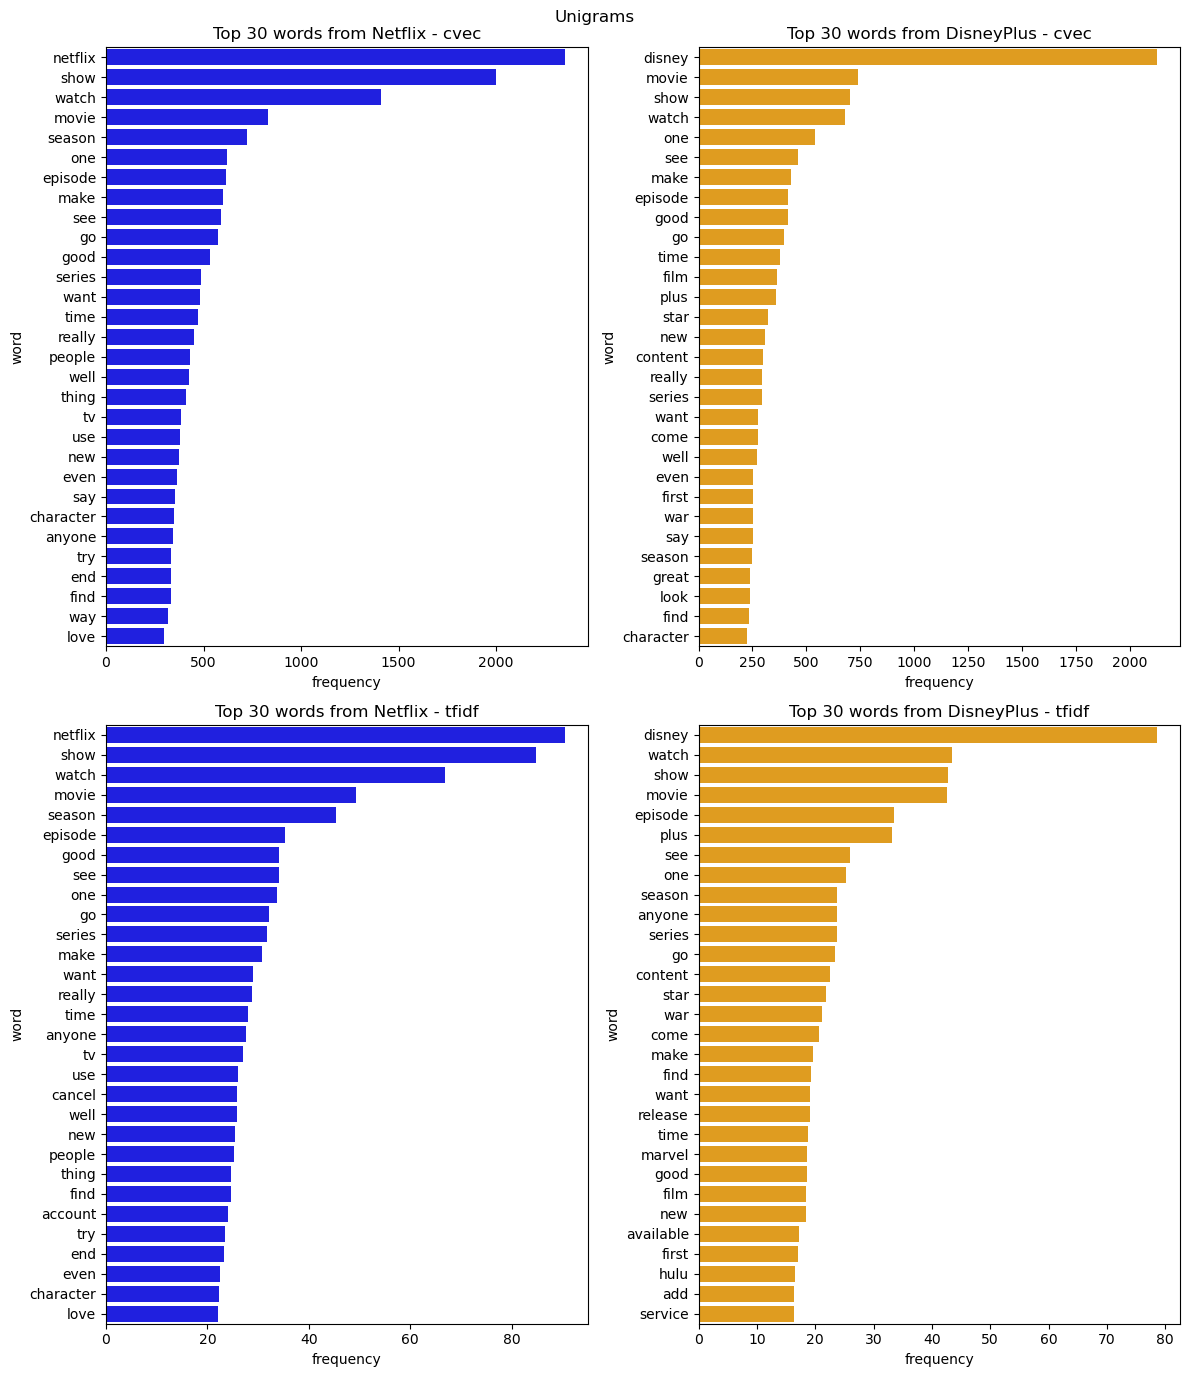

In [93]:
# plotting unigrams

fig, axes = plt.subplots(2, 2, figsize=(12, 14))

plt.suptitle('Unigrams')

# Plotting a barplot of the top 30 words from each subreddit

# CountVectorized words
sns.barplot(data=df_nf_sum.head(30), x='frequency', y='word', color='blue', label='Words Netflix', ax=axes[0,0])
axes[0,0].set_title('Top 30 words from Netflix - cvec')

sns.barplot(data=df_dp_sum.head(30), x='frequency', y='word', color='orange',label='Words Disneyplus', ax=axes[0,1])
axes[0,1].set_title('Top 30 words from DisneyPlus - cvec')

# TF-IDF Vectorized words
sns.barplot(data=df_nf_sum_tf.head(30), x='frequency', y='word', color='blue', label='Words Netflix', ax=axes[1,0])
axes[1,0].set_title('Top 30 words from Netflix - tfidf')

sns.barplot(data=df_dp_sum_tf.head(30), x='frequency', y='word', color='orange',label='Words Disneyplus', ax=axes[1,1])
axes[1,1].set_title('Top 30 words from DisneyPlus - tfidf')

plt.tight_layout()

Count vectorizer converts a collection of text documents into a matrix of token word counts while TF-IDF vectorizer does something similar but it also takes into account the word frequency within the documents and their importance in the entire corpus.

Comparing the unigrams, there are common words between Netflix and Disney+ subreddit posts but we can see that the brands seem to be unique in each subreddit.

From the charts, we could also observe the different placing of the words. In the top 30 words from Netflix subreddit, `episode` and `series` are higher in rank in the TF-IDF chart as greater weights are placed on them.

From the common words in both subreddits, we can utilize to channel these top words towards Netflix through Search Engine Optimization (SEO).

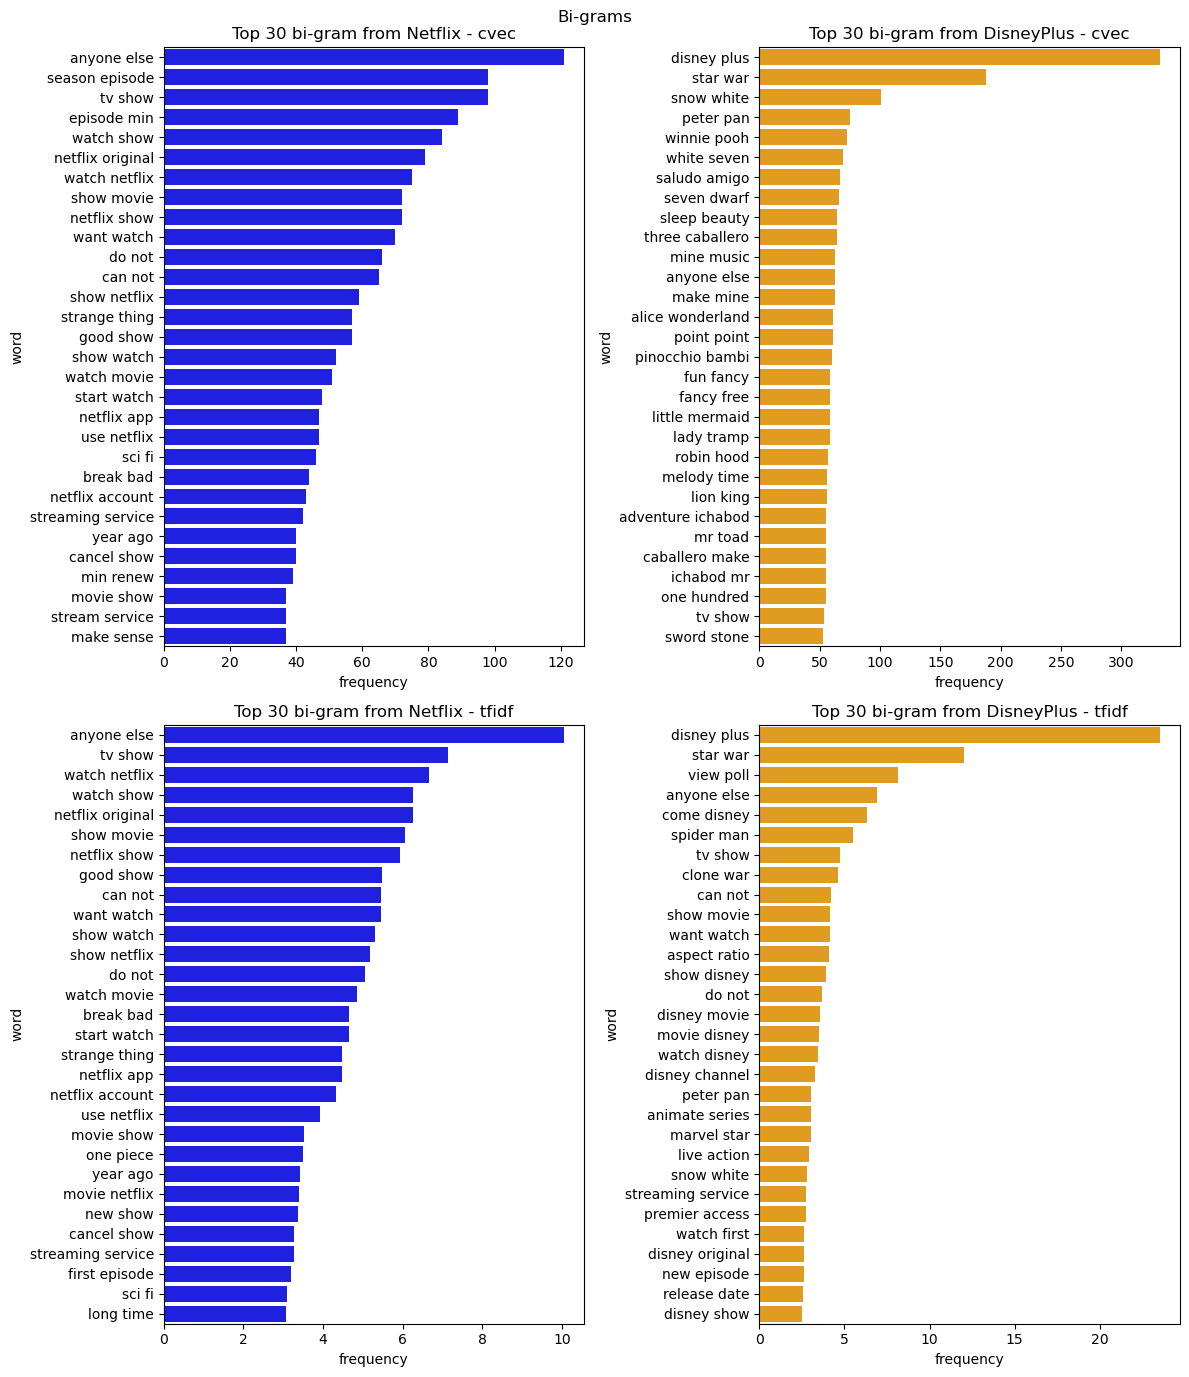

In [94]:
# plotting unigrams

fig, axes = plt.subplots(2, 2, figsize=(12, 14))

plt.suptitle('Bi-grams')

# Plotting a barplot of the top 30 bi-grams from each subreddit

# CountVectorized bi-grams
sns.barplot(data=df_nf_bi_sum.head(30), x='frequency', y='word',color='blue', label='Words Netflix', ax=axes[0,0])
axes[0,0].set_title('Top 30 bi-gram from Netflix - cvec')

sns.barplot(data=df_dp_bi_sum.head(30), x='frequency', y='word',color='orange',label='Words Disneyplus', ax=axes[0,1])
axes[0,1].set_title('Top 30 bi-gram from DisneyPlus - cvec')

# TF-IDF vectorized bi-grams
sns.barplot(data=df_nf_bi_sum_tf.head(30), x='frequency', y='word',color='blue', label='Words Netflix', ax=axes[1,0])
axes[1,0].set_title('Top 30 bi-gram from Netflix - tfidf')

# Plot bars of the top 30 bi-grams from disney+ in orange

sns.barplot(data=df_dp_bi_sum_tf.head(30), x='frequency', y='word',color='orange',label='Words Disneyplus', ax=axes[1,1])
axes[1,1].set_title('Top 30 bi-gram from DisneyPlus - tfidf')

plt.tight_layout()

Unlike the unigrams, the bi-grams seem to be more unique to each subreddits. The bi-grams from Disney+ seems to focus on the show titles that are released on the platform.

Similar to the unigrams, we can utilize the top bi-grams from Disney+ to introduce or market similar movie or series genre that are available on Netflix.

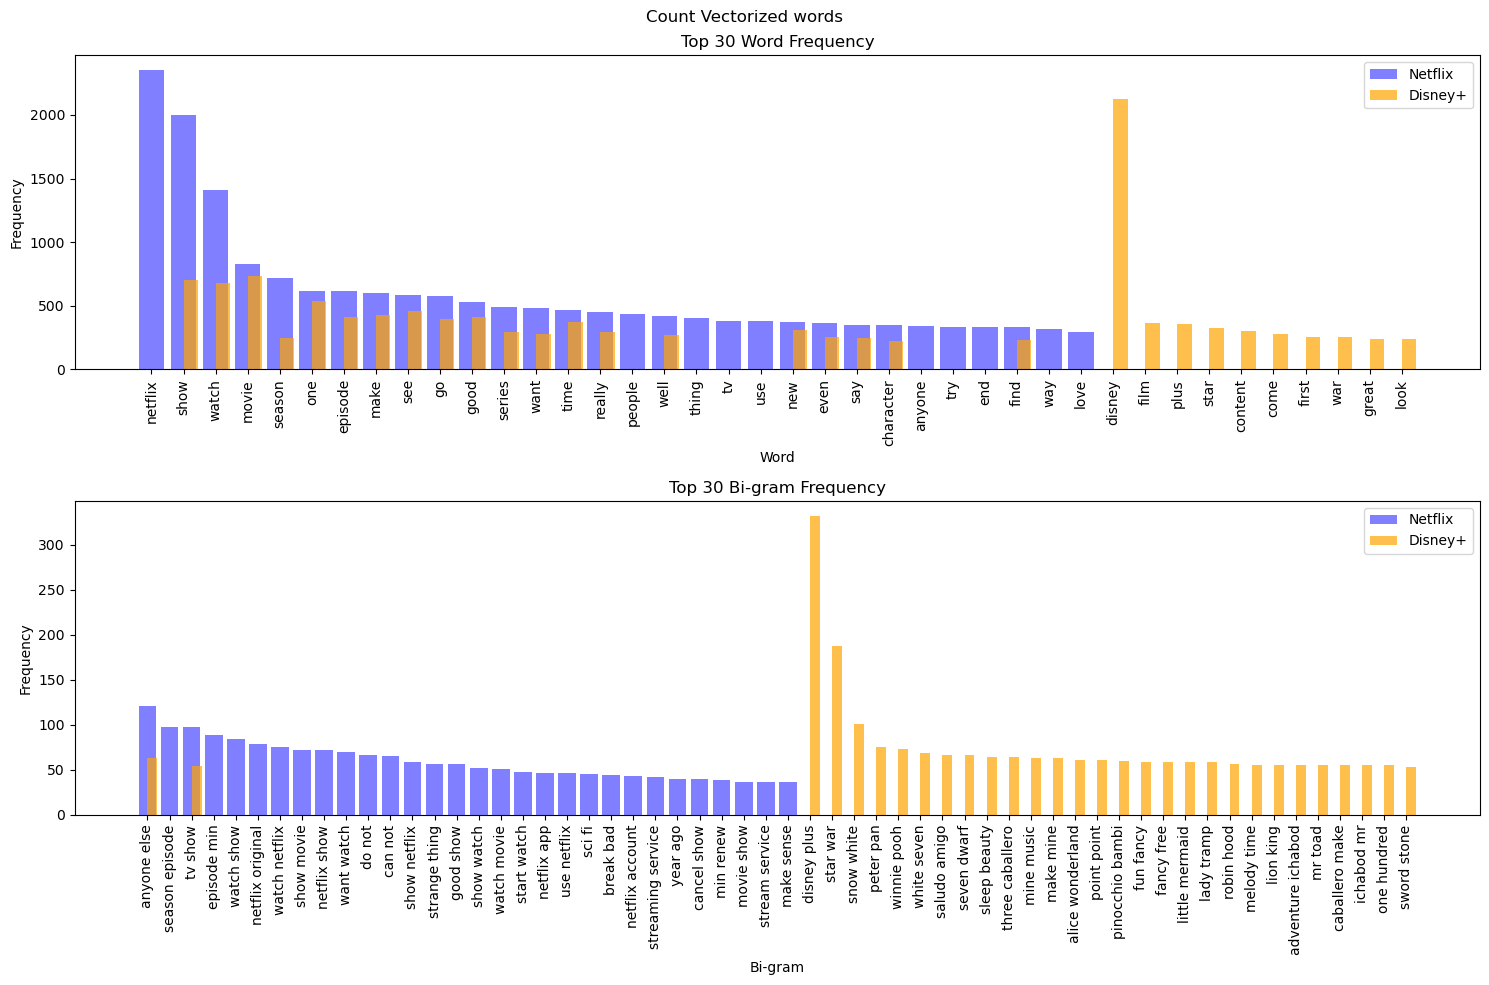

In [85]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

plt.suptitle('Count Vectorized words')

# Plotting Netflix top 30 words - Left Subplot
axs[0].bar(df_nf_sum.head(30)['word'], df_nf_sum.head(30)['frequency'], color='blue', alpha=0.5, label='Netflix')
axs[0].bar(df_dp_sum.head(30)['word'], df_dp_sum.head(30)['frequency'], color='orange', alpha=0.7, label='Disney+', width=0.45, align='edge')
axs[0].set_xlabel('Word')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Top 30 Word Frequency')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=90)

# Plotting Disney+ top 30 words- Right Subplot
axs[1].bar(df_nf_bi_sum.head(30)['word'], df_nf_bi_sum.head(30)['frequency'], color='blue', alpha=0.5, label='Netflix')
axs[1].bar(df_dp_bi_sum.head(30)['word'], df_dp_bi_sum.head(30)['frequency'], color='orange', alpha=0.7, label='Disney+', width=0.45, align='edge')
axs[1].set_xlabel('Bi-gram')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Top 30 Bi-gram Frequency')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=90)

# Adjust the space between subplots
plt.tight_layout()

# Show the figure
plt.show()

Visualising the top 30 words from both subreddits and we can clearly see the top common words between the subreddits and in general, these words come from the Netflix subreddits. From the bi-gram, we can interpret that the posts on the Disney+ subreddit contain more movie titles, having Star Wars to be the most popular show. 

We could utilise this to match these movies from Disney+ with the ones in Netflix with the same genre or similar plots to appeal to users of these platforms.

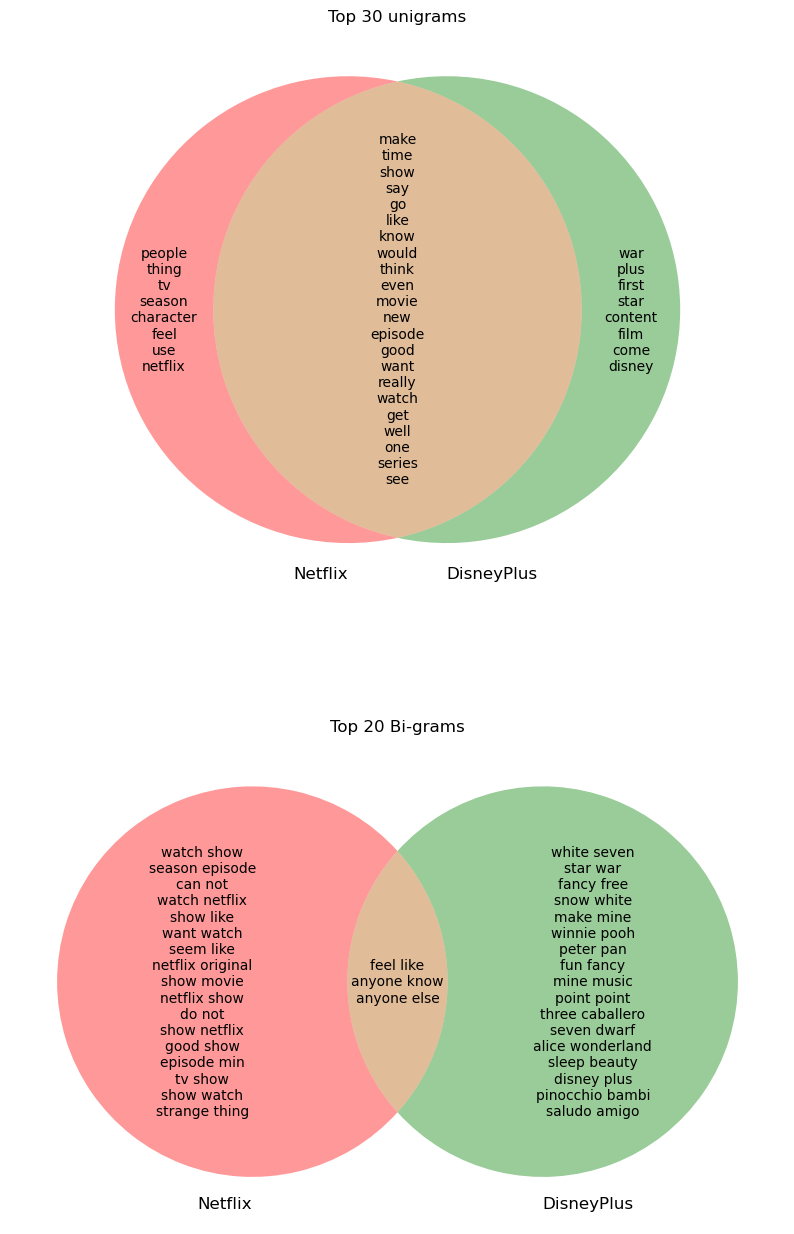

In [58]:
# getting the top 30 words from each subreddit and placing them in a set
set_a = set(df_nf_sum['word'].head(30))
set_b = set(df_dp_sum['word'].head(30))

# getting the top 20 bi-grams from each subreddit and placing them in a set
set_c = set(df_nf_bi_sum['word'].head(20))
set_d = set(df_dp_bi_sum['word'].head(20))

fig, axs = plt.subplots(2, 1, figsize=(10, 16))
# Create the first Venn diagram
axs[0].set_title('Top 30 unigrams')
diagram = venn2([set_a, set_b], set_labels=('Netflix', 'DisneyPlus'), ax=axs[0])
diagram.get_label_by_id('10').set_text('\n'.join(map(str,set_a-set_b)))
diagram.get_label_by_id('11').set_text('\n'.join(map(str,set_a&set_b)))
diagram.get_label_by_id('01').set_text('\n'.join(map(str,set_b-set_a)))

# Create the second Venn diagram
axs[1].set_title('Top 20 Bi-grams')
diagram2 = venn2([set_c, set_d], set_labels=('Netflix', 'DisneyPlus'), ax=axs[1])
diagram2.get_label_by_id('10').set_text('\n'.join(map(str,set_c-set_d)))
diagram2.get_label_by_id('11').set_text('\n'.join(map(str,set_c&set_d)))
diagram2.get_label_by_id('01').set_text('\n'.join(map(str,set_d-set_c)))

# Show the combined plot
plt.show()


Having the words in a venn diagram allows us to see the top common words easily and get a clearer picture of the kind of words and bi-grams that are mostly used on the subreddit posts.

The unigrams consist of mostly overlapping words that can be used to connect the viewers to Netflix. From the bi-grams, most of them are movie titles or the titles of the shows that are available on the platform. These can be useful to understand the genre and the type of content that Netflix could produce that are similar yet different from the movies in Disney+. For example, when people look for the movie `Alice in Wonderland`, there could be matching keywords that could advertise the show that is available in Netflix such as `Alice in Borderland`.

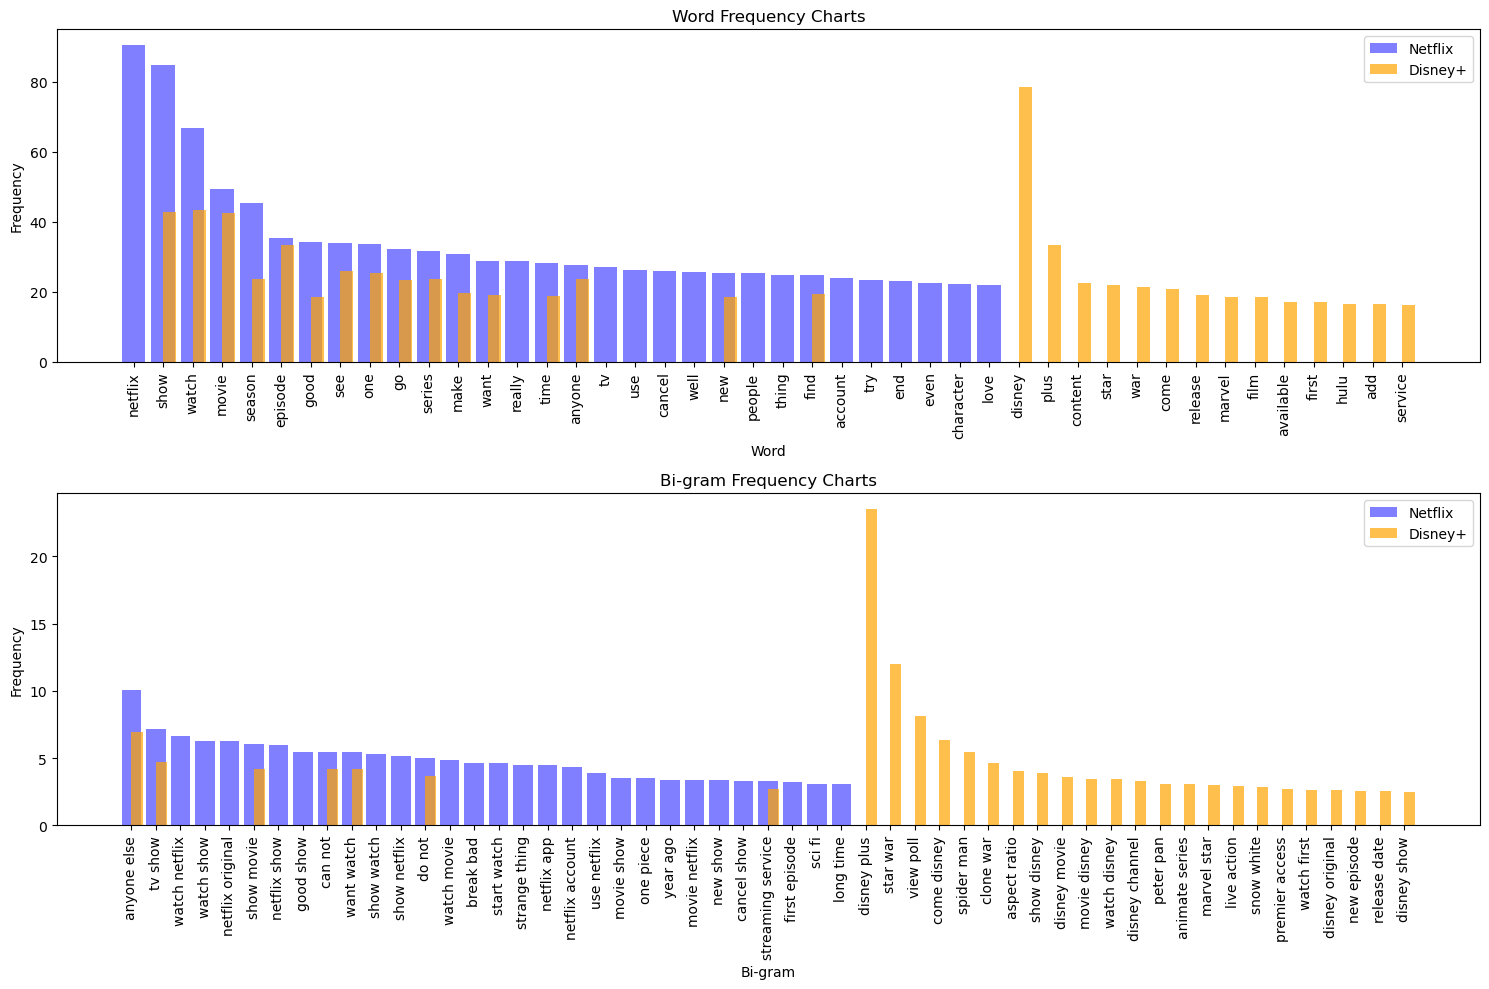

In [86]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plotting Netflix top 30 words - Left Subplot
axs[0].bar(df_nf_sum_tf.head(30)['word'], df_nf_sum_tf.head(30)['frequency'], color='blue', alpha=0.5, label='Netflix')
axs[0].bar(df_dp_sum_tf.head(30)['word'], df_dp_sum_tf.head(30)['frequency'], color='orange', alpha=0.7, label='Disney+', width=0.45, align='edge')
axs[0].set_xlabel('Word')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Word Frequency Charts')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=90)

# Plotting Disney+ top 30 words - Right Subplot
axs[1].bar(df_nf_bi_sum_tf.head(30)['word'], df_nf_bi_sum_tf.head(30)['frequency'], color='blue', alpha=0.5, label='Netflix')
axs[1].bar(df_dp_bi_sum_tf.head(30)['word'], df_dp_bi_sum_tf.head(30)['frequency'], color='orange', alpha=0.7, label='Disney+', width=0.45, align='edge')
axs[1].set_xlabel('Bi-gram')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Bi-gram Frequency Charts')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=90)

# Adjust the space between subplots
plt.tight_layout()

# Show the figure
plt.show()

This chart shows the count of the top 30 words and bi-grams from each subreddit group. Through the overlapping words, we can see that posts on Netflix subreddit have more word count than the ones from Disney+ subreddit. 

Most of the bi-grams from Netflix do not reflect the show titles which shows that the posts could be mostly about the content that Netflix has rather than the specific shows that the subreddit users are curious about. This could signal the Content team to schedule new series and movies.

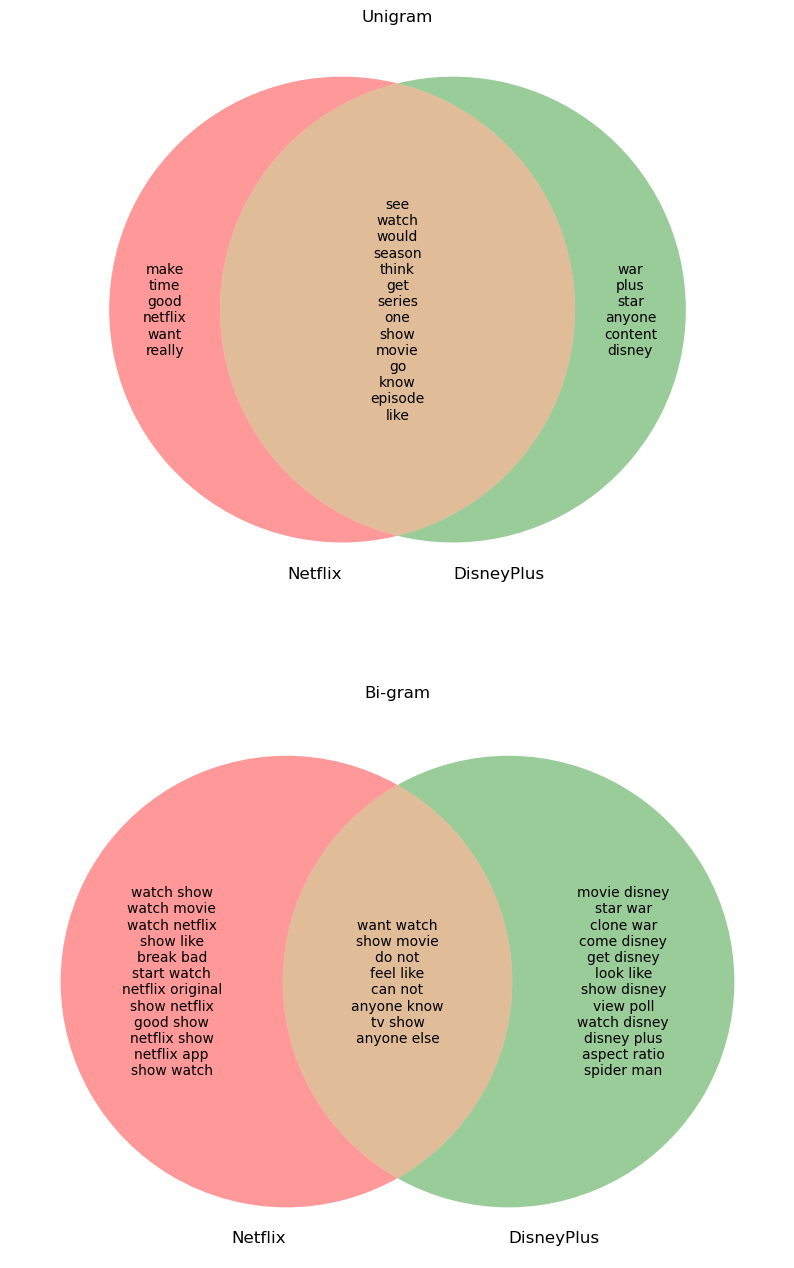

In [53]:
# getting the top 20 words from each subreddit and placing them in a set
set_a = set(df_nf_sum_tf['word'].head(20))
set_b = set(df_dp_sum_tf['word'].head(20))

# getting the top 20 bi-grams from each subreddit and placing them in a set
set_c = set(df_nf_bi_sum_tf['word'].head(20))
set_d = set(df_dp_bi_sum_tf['word'].head(20))

fig, axs = plt.subplots(2, 1, figsize=(10, 16))
# Create the first Venn diagram
axs[0].set_title('Unigram')
diagram = venn2([set_a, set_b], set_labels=('Netflix', 'DisneyPlus'), ax=axs[0])
diagram.get_label_by_id('10').set_text('\n'.join(map(str,set_a-set_b)))
diagram.get_label_by_id('11').set_text('\n'.join(map(str,set_a&set_b)))
diagram.get_label_by_id('01').set_text('\n'.join(map(str,set_b-set_a)))

# Create the second Venn diagram
axs[1].set_title('Bi-gram')
diagram2 = venn2([set_c, set_d], set_labels=('Netflix', 'DisneyPlus'), ax=axs[1])
diagram2.get_label_by_id('10').set_text('\n'.join(map(str,set_c-set_d)))
diagram2.get_label_by_id('11').set_text('\n'.join(map(str,set_c&set_d)))
diagram2.get_label_by_id('01').set_text('\n'.join(map(str,set_d-set_c)))

# Show the combined plot
plt.show()


Having these overlapping charts and venn diagrams help to see the common words between the subreddits. But we also have to note that these are only the top 20 or 30 words from the subreddits. There could also be more overlapping words which could be in the top 30 words in one subreddit but a less used word in the other subreddit that are not shown on the charts.

#### Next part:

[Part III - Pre-processing and Modeling](Pre_Processing_Model.ipynb)